# Logistic Regression for Telco Churn Analysis

#### Utilizing data retrieved from a Kaggle dataset to build a logistic regression model aimed at predicting customer churn rates.  

Also included is a statistical analysis to identify the most significant features and their correlation to churn rates.  

In [58]:
import requests
import pandas as pd
import numpy as np
import kagglehub
import os
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# from sklearn.datasets import make_classification
import statistics

warnings.filterwarnings("ignore")
;

''

## Data Acquisition

In [3]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn",path='WA_Fn-UseC_-Telco-Customer-Churn.csv')

100%|██████████| 955k/955k [00:00<00:00, 1.85MB/s]


In [4]:
destination = os.environ.get('LR_Destination')

alr_exists = str(destination + '/' + 'WA_Fn-UseC_-Telco-Customer-Churn.csv')

if os.path.exists(alr_exists):
        os.remove(alr_exists)
        print(f"File deleted sucessfully.")
else:
        print(f"File not found.")

File deleted sucessfully.


In [5]:
source = os.environ.get('LR_SOURCE')

allfiles = os.listdir(source)

for f in allfiles:
        src_path = os.path.join(source, f)
        dst_path = os.path.join(destination, f)
        os.rename(src_path, dst_path)

In [6]:
str(destination + '/' + 'WA_Fn-UseC_-Telco-Customer-Churn.csv')  
ChurnData = pd.read_csv(str(destination + '/' + 'WA_Fn-UseC_-Telco-Customer-Churn.csv'))

## Data Proccessing

In [7]:
#Pre-Processing of Data, removing CustomerID, and Converting TotalCharges into a float.
ChurnData.drop('customerID',axis=1,inplace=True)
ChurnData['TotalCharges'] = pd.to_numeric(ChurnData['TotalCharges'], errors='coerce').fillna(pd.to_numeric(ChurnData['TotalCharges'], errors='coerce').mean())

In [8]:
# most likely the columns that are categorical -> not numerical (Creating function to dynamically assign integer values to categorical information)
# Some data is multicollinear, meaning that there is redundant information.
for column in ChurnData:
    if(ChurnData[column].dtype == 'object' and len(ChurnData[column].unique()) > 2):
            ChurnData = pd.get_dummies(ChurnData, columns=[str(column)], drop_first=True)

#Convert booleans created from pd.get_dummies and map them dynamically into 0s and 1s
for column in ChurnData:
      if(ChurnData[column].dtypes == bool):
            ChurnData[column] = ChurnData[column].astype(int)

In [9]:
#Retrieving columns that were generated by pandas dummy variables and calculating VIF for detecting colinearity
data = ChurnData.loc[:, ChurnData.columns.str.contains("_")]

vif_df = pd.DataFrame()
vif_df["feature"] = data.columns
vif_df["VIF_Score"] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]

#Retrieving scores that were greater than 10, indicates need to be dropped from original dataset
vif_df = vif_df[vif_df["VIF_Score"] > 10]['feature']

In [10]:
cols = [col for col in ChurnData.columns if col not in vif_df.to_numpy()]
ChurnData = ChurnData.loc[:, cols]

In [11]:
#Mapping remaining yes/no columns to 0s and 1s dynamically
yes_no_map = {'Yes' : 1, 'No' : 0}

map_yes_no_columns = []
for cols in ChurnData:
    if 'Yes' in ChurnData[cols].unique() or 'No' in ChurnData[cols].unique():
        map_yes_no_columns.append(ChurnData[cols].name)

for row in ChurnData[map_yes_no_columns]:
    ChurnData[row] = ChurnData[map_yes_no_columns][row].map(yes_no_map)

ChurnData.rename(columns={'gender' : 'Male'}, inplace=True)

In [12]:
gender_map = {'Male': 1, 'Female': 0}

ChurnData['Male'] = ChurnData["Male"].map(gender_map)

In [13]:
Churn_X = ChurnData.drop('Churn', axis=1)
Churn_y = ChurnData['Churn']

In [14]:
from imblearn.over_sampling import SMOTE

Churn_X = ChurnData.drop('Churn', axis=1)
Churn_y = ChurnData['Churn']

param_grid = {
    'penalty': ['l1', 'l2','elasticnet','none'],
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter': [50, 100, 200, 500, 1000]
}

scaler = MinMaxScaler()

Churn_X = scaler.fit_transform(Churn_X)

CD_X_train, CD_X_test, CD_y_train, CD_y_test = train_test_split(
    Churn_X, Churn_y, test_size=0.2, random_state=42
)

gs_cv = GridSearchCV(LogisticRegression(), param_grid, cv=5,verbose=True, n_jobs=1)
best_clf = gs_cv.fit(CD_X_train, CD_y_train)

rs_cv = RandomizedSearchCV(LogisticRegression(), param_grid, cv=5, verbose=True, n_jobs=1)
best_clf2 = rs_cv.fit(CD_X_train, CD_y_train)

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [15]:
grid_model = LogisticRegression(C=best_clf.best_params_['C'], max_iter=best_clf.best_params_['max_iter'], \
    penalty=best_clf.best_params_['penalty'], solver=best_clf.best_params_['solver'])

grid_model.fit(CD_X_train, CD_y_train)
grid_churn_pred = grid_model.predict(CD_X_test)


#######################################################################################################################

random_model = LogisticRegression(C=best_clf2.best_params_['C'], max_iter=best_clf2.best_params_['max_iter'], \
    penalty=best_clf2.best_params_['penalty'], solver=best_clf2.best_params_['solver'])

random_model.fit(CD_X_train, CD_y_train)
random_churn_pred = random_model.predict(CD_X_test)    

#######################################################################################################################

model = LogisticRegression()

model.fit(CD_X_train, CD_y_train)
model_pred = model.predict(CD_X_test)

print("Accuracy of RandomizedSearchCV: {:.2f}% \n ".format(accuracy_score(CD_y_test, random_churn_pred) * 100))
print("Classification Report: \n \n" + classification_report(CD_y_test, random_churn_pred))

print("Accuracy of GridSearchCV: {:.2f}% \n".format(accuracy_score(CD_y_test, grid_churn_pred) * 100))
print("Classification Report: \n \n" + classification_report(CD_y_test, grid_churn_pred))

print("Accuracy of LogisticRegression [No Optimized Hyperparameters]: {:.2f}% \n".format(accuracy_score(CD_y_test, model_pred) * 100))
print("Classification Report: \n \n" + classification_report(CD_y_test, model_pred))


Accuracy of RandomizedSearchCV: 81.33% 
 
Classification Report: 
 
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      1036
           1       0.73      0.47      0.57       373

    accuracy                           0.81      1409
   macro avg       0.78      0.70      0.73      1409
weighted avg       0.80      0.81      0.80      1409

Accuracy of GridSearchCV: 82.54% 

Classification Report: 
 
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1036
           1       0.71      0.58      0.64       373

    accuracy                           0.83      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.83      0.82      1409

Accuracy of LogisticRegression [No Optimized Hyperparameters]: 82.11% 

Classification Report: 
 
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
          

## Metrics and Comparisons

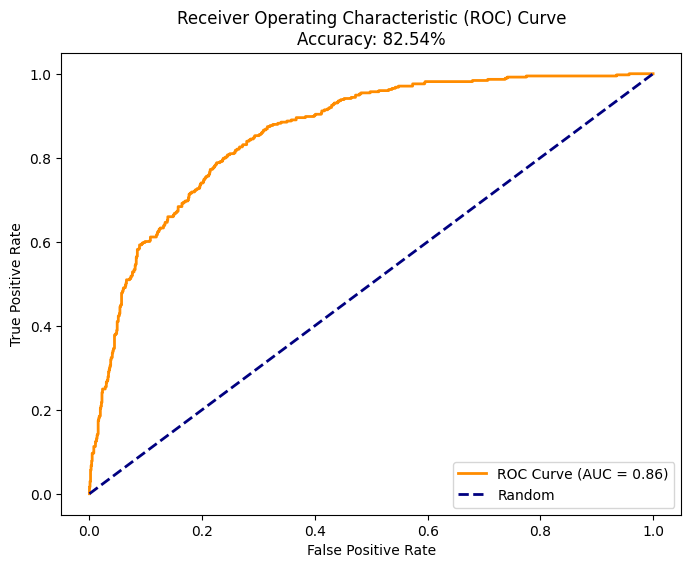

In [16]:
#AUC-ROC curve plots True Positive Rate against False Positive Rate at different thresholds showing how well a model can distinguish between customers that stay vs leave.
#TPR = p(True Positives are found)
#FPR = p(False Positives are found)
ChurnModel = grid_model.fit(CD_X_train, CD_y_train)

y_prob = ChurnModel.predict_proba(CD_X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(CD_y_test, y_prob)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(accuracy_score(CD_y_test, grid_churn_pred) * 100))
plt.legend(loc="lower right")
plt.show()

## Statistical Analysis

In [55]:
#statsmodels.api has a package [logit] that provides a summary on the independent and dependent variables

sm.Logit(Churn_y, Churn_X)
mcs = sm.Logit(Churn_y, Churn_X).fit().summary(xname=[header for header in ChurnData.drop('Churn', axis=1)])

relevant_metrics = pd.DataFrame()
model_coefficients = pd.DataFrame()

for i in range(2):
    if i == 0:
        relevant_metrics = pd.read_html(mcs.tables[0].as_html())
    else:
        model_coefficients = pd.read_html(mcs.tables[1].as_html())

mc_map = {0: 'ColumnName', 1: 'Coef', 2: 'Std. Err', 3: 'z', 4: 'P>|z|', 5: '[0.025', 6: '0.975]'}

model_coefficients[0].rename(mc_map,axis=1,inplace=True)
model_coefficients = model_coefficients[0].loc[1:];

relevant_metrics = relevant_metrics[0]

Optimization terminated successfully.
         Current function value: 0.414247
         Iterations 8


In [56]:
rename_nothing = {0: '', 1: ''}

other_info = relevant_metrics.iloc[:,[0,1]].rename(columns = rename_nothing)
other_info

,,
0,Dep. Variable:,Churn
1,Model:,Logit
2,Method:,MLE
3,Date:,"Sat, 01 Mar 2025"
4,Time:,19:39:40
5,converged:,True
6,Covariance Type:,nonrobust


In [57]:
model_coefficients.loc[model_coefficients['P>|z|'].astype(float) < .05].sort_values(by='Coef',ascending=False)

,ColumnName,Coef,Std. Err,z,P>|z|,[0.025,0.975]
8,MonthlyCharges,2.9233,0.543,5.383,0.000,1.859,3.988
9,TotalCharges,2.5991,0.595,4.370,0.000,1.433,3.765
7,PaperlessBilling,0.3479,0.074,4.677,0.000,0.202,0.494
22,PaymentMethod_Electronic check,0.3078,0.094,3.258,0.001,0.123,0.493
2,SeniorCitizen,0.2132,0.085,2.522,0.012,0.047,0.379
5,tenure,-4.1690,0.433,-9.630,0.000,-5.018,-3.321
20,Contract_Two year,-1.4024,0.176,-7.979,0.000,-1.747,-1.058
6,PhoneService,-1.2912,0.159,-8.118,0.000,-1.603,-0.979
19,Contract_One year,-0.6755,0.107,-6.293,0.000,-0.886,-0.465
13,OnlineSecurity_Yes,-0.5431,0.094,-5.801,0.000,-0.727,-0.360
